# Natural Language Processing. Assignment 1. Tokenization.

In this assignment, you need to implement, train, and analyze a Byte-Pair Encoding (BPE) tokenizer.

The assignment consist of 3 tasks. When you finish all the tasks, create a GitHub repository for this assignment (you can use this repository later for the other assignments) and submit this notebook in the repository. Leave `requirements.txt` file if your code requires additional installations. Submit the link to the repository in Moodle.

## Task 1: Data Preparation and Vocabulary Size Selection (3 points)

First, load the [Brown corpus](https://en.wikipedia.org/wiki/Brown_Corpus). After loading the corpus, you need to select the appropriate vocabulary size for the BPE tokenizer. The appropriate vocabulary size is the minimal vocabulary size that covers at least 90% of the words in the corpus. The coverage is calculated according to the following formula:



$$ \text{coverage}(k) = \frac{\sum_{r=1}^{k} f(r)}{\sum_{r=1}^{N} f(r)} $$



where $f(r)$ is the frequency of the top-$r$ word, $k$ is the number of top-$k$ tokens included in vocab, $N$ is the total unique words in corpus.

So, for this task you need to do the following:

1. Load the Brown corpus (0.5 points)
2. Plot cumulative coverage vs. vocabulary size for the loaded corpus (1 point)
3. Select the appropriate vocabulary size (0.5 point)
4. Answer the questions:
    1. Why the coverage slows down the increase as the vocabulary size increases? (0.5 point)
    2. Which empirical law explains the slowing down increase of the coverage? (0.5 point)

[nltk_data] Downloading package brown to
[nltk_data]     C:\Users\emil1\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\brown.zip.


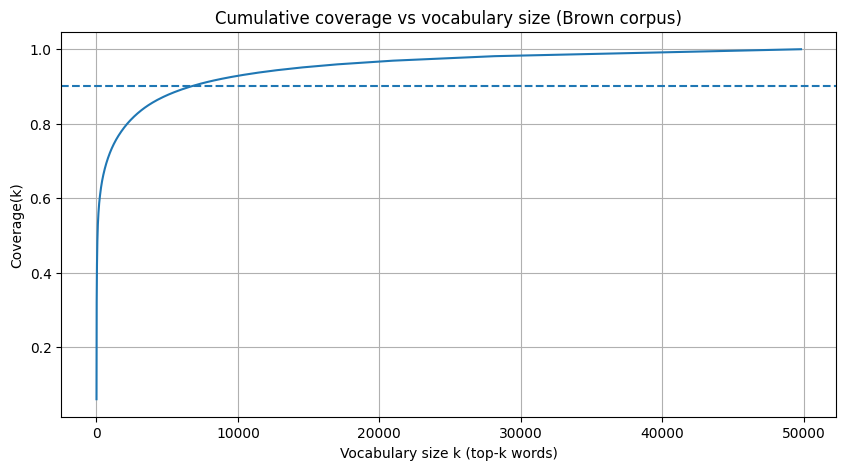

Minimal k for >= 90% coverage: k = 6671
Coverage(k=6671) = 0.9000

Q1: Why does coverage growth slow down as vocab size increases?
A1: Because the most frequent words cover a large fraction of the corpus. As k grows, we add rarer and rarer words, each contributing very little, so coverage increases slower.

Q2: Which empirical law explains this?
A2: Zipf's law (power-law distribution of word frequencies).


In [1]:
# Task 1: Data Preparation and Vocabulary Size Selection

import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

import nltk
from nltk.corpus import brown

# 1) Load Brown corpus
try:
    brown.words()
except LookupError:
    nltk.download("brown")

# Берём слова, приводим к lowercase
words = [w.lower() for w in brown.words()]

# Частоты слов
freq = Counter(words)
# Сортируем по убыванию частоты
sorted_items = sorted(freq.items(), key=lambda x: x[1], reverse=True)
sorted_freqs = np.array([c for _, c in sorted_items], dtype=np.float64)

# 2) Plot cumulative coverage vs vocab size
total = sorted_freqs.sum()
cum = np.cumsum(sorted_freqs)
coverage = cum / total

plt.figure(figsize=(10, 5))
plt.plot(np.arange(1, len(coverage) + 1), coverage)
plt.axhline(0.90, linestyle="--")
plt.title("Cumulative coverage vs vocabulary size (Brown corpus)")
plt.xlabel("Vocabulary size k (top-k words)")
plt.ylabel("Coverage(k)")
plt.grid(True)
plt.show()

# 3) Select minimal vocabulary size to cover >= 90%
k_90 = int(np.searchsorted(coverage, 0.90) + 1)
print(f"Minimal k for >= 90% coverage: k = {k_90}")
print(f"Coverage(k={k_90}) = {coverage[k_90-1]:.4f}")

# 4) Answer questions (as text output)
print("\nQ1: Why does coverage growth slow down as vocab size increases?")
print("A1: Because the most frequent words cover a large fraction of the corpus. "
      "As k grows, we add rarer and rarer words, each contributing very little, "
      "so coverage increases slower.")

print("\nQ2: Which empirical law explains this?")
print("A2: Zipf's law (power-law distribution of word frequencies).")

## Task 2: Implement Byte-Pair Encoding (BPE) Tokenizer (4 points)

Implement the [BPE tokenizer](https://arxiv.org/pdf/1508.07909) as the `BPETokenizer` class.

The class should contain correctly implemented:

* `train` method (1.5 points).
* `tokenize` method (1.5 points).

The code should have docstrings and comments (1 point).

In [2]:
# Task 2: Implement Byte-Pair Encoding (BPE) Tokenizer

import re
from collections import Counter, defaultdict
from typing import List, Tuple, Dict, Iterable


class BPETokenizer:
    """
    Byte-Pair Encoding (BPE) tokenizer (Sennrich et al., 2016 style).

    Idea:
    - Start with character-level tokens for each word + end-of-word symbol </w>.
    - Iteratively merge the most frequent adjacent pair of tokens.
    - Store merges and apply them in the same order at tokenization time.

    Parameters
    ----------
    vocab_size : int
        Target vocabulary size (approximate): number of unique subword tokens.
        Training stops when we reach this size or when no more pairs exist.
    lowercase : bool
        If True, lowercases inputs during train/tokenize.
    """

    def __init__(self, vocab_size: int, lowercase: bool = True):
        self.vocab_size = int(vocab_size)
        self.lowercase = lowercase

        # List of merges in order: [(a,b), ...]
        self.merges: List[Tuple[str, str]] = []

        # Set of subword tokens after training
        self.subword_vocab: set[str] = set()

        # End-of-word marker
        self.eow = "</w>"

    def _normalize_word(self, w: str) -> str:
        return w.lower() if self.lowercase else w

    def _word_to_symbols(self, word: str) -> List[str]:
        """
        Convert a word into initial symbol sequence: characters + </w>.
        Example: "cat" -> ["c","a","t","</w>"]
        """
        word = self._normalize_word(word)
        if word == "":
            return [self.eow]
        return list(word) + [self.eow]

    def _get_pair_stats(self, word_counts: Dict[Tuple[str, ...], int]) -> Dict[Tuple[str, str], int]:
        """
        Count frequencies of adjacent pairs across the whole training word inventory.
        word_counts maps tokenized-word (tuple of symbols) -> count.
        """
        pair_freq = defaultdict(int)
        for symbols, cnt in word_counts.items():
            for i in range(len(symbols) - 1):
                pair_freq[(symbols[i], symbols[i + 1])] += cnt
        return pair_freq

    def _merge_pair_in_word(self, symbols: Tuple[str, ...], pair: Tuple[str, str]) -> Tuple[str, ...]:
        """
        Apply one merge operation to one tokenized word.
        Merge all occurrences of (a,b) -> (ab).
        """
        a, b = pair
        merged = []
        i = 0
        while i < len(symbols):
            if i < len(symbols) - 1 and symbols[i] == a and symbols[i + 1] == b:
                merged.append(a + b)
                i += 2
            else:
                merged.append(symbols[i])
                i += 1
        return tuple(merged)

    def train(self, words: Iterable[str]) -> None:
        """
        Train BPE merges on a word list.

        Steps:
        1) Build initial word inventory in character symbols (+ </w>) with counts.
        2) While vocabulary size not reached:
           - count adjacent token pairs
           - pick the most frequent pair
           - merge it everywhere
        """
        # Count normalized words
        word_freq = Counter(self._normalize_word(w) for w in words)

        # Convert each unique word into symbol tuple and keep its frequency
        word_counts: Dict[Tuple[str, ...], int] = {}
        for w, c in word_freq.items():
            sym = tuple(self._word_to_symbols(w))
            word_counts[sym] = word_counts.get(sym, 0) + c

        # Initialize subword vocab with all characters + </w>
        self.subword_vocab = set()
        for sym_tuple in word_counts:
            for s in sym_tuple:
                self.subword_vocab.add(s)

        # Iteratively merge
        while len(self.subword_vocab) < self.vocab_size:
            pair_stats = self._get_pair_stats(word_counts)
            if not pair_stats:
                break

            best_pair = max(pair_stats.items(), key=lambda x: x[1])[0]
            self.merges.append(best_pair)

            # Merge in all words
            new_word_counts = {}
            for sym_tuple, cnt in word_counts.items():
                merged = self._merge_pair_in_word(sym_tuple, best_pair)
                new_word_counts[merged] = new_word_counts.get(merged, 0) + cnt
            word_counts = new_word_counts

            # Update subword vocab
            self.subword_vocab = set()
            for sym_tuple in word_counts:
                for s in sym_tuple:
                    self.subword_vocab.add(s)

            # If no growth (rare), stop
            if len(self.merges) > 0 and len(self.subword_vocab) == 0:
                break

    def encode_word(self, word: str) -> List[str]:
        """
        Apply learned merges to a single word and return list of subword tokens.
        """
        symbols = tuple(self._word_to_symbols(word))

        for pair in self.merges:
            symbols = self._merge_pair_in_word(symbols, pair)

        # Remove </w> from output tokens (usually not emitted as a token)
        out = list(symbols)
        if len(out) > 0 and out[-1] == self.eow:
            out = out[:-1]
        return out

    def tokenize(self, text: str) -> List[str]:
        """
        Tokenize a text string into subword tokens.
        Simple word/punctuation split + BPE for word pieces.
        """
        # Simple token split: words or single punctuation
        tokens = re.findall(r"\w+|[^\w\s]", text, flags=re.UNICODE)

        out_tokens: List[str] = []
        for tok in tokens:
            # If it's a word-like token => apply BPE, else keep punctuation as-is
            if re.fullmatch(r"\w+", tok, flags=re.UNICODE):
                out_tokens.extend(self.encode_word(tok))
            else:
                out_tokens.append(tok)
        return out_tokens

## Task 3: Tokenizer Training and Analysis (3 points)

1. Train the `BPETokenizer` on the Brown corpus with the appropriate vocabulary size selected in Task 1 (1 points)
2. Use the Brown corpus (1000 samples) to calculate the mean and standard deviation of
    * tokenizer's fertility (1 points)
    * length of the tokenized sentence (1 points)

In [3]:
# Task 3: Tokenizer Training and Analysis

import numpy as np
from nltk.corpus import brown

# 1) Train BPETokenizer on Brown corpus with vocab size from Task 1
# (используем k_90, который ты посчитал в Task 1)
bpe = BPETokenizer(vocab_size=k_90, lowercase=True)

train_words = [w for w in brown.words()]
bpe.train(train_words)

print(f"Trained BPE. merges={len(bpe.merges)}, subword_vocab_size={len(bpe.subword_vocab)}")

# 2) Use Brown corpus (1000 samples) to compute:
#    - fertility (mean, std)
#    - tokenized sentence length (mean, std)

# Берём 1000 предложений
sents = brown.sents()
n = min(1000, len(sents))
sample_sents = sents[:n]

fertilities = []
sent_lengths = []

for sent in sample_sents:
    # нормализуем слова: только "слова" (без чистой пунктуации)
    words = [w for w in sent if re.fullmatch(r"\w+", w, flags=re.UNICODE)]
    if len(words) == 0:
        continue

    total_subwords = 0
    for w in words:
        total_subwords += len(bpe.encode_word(w))

    fertility = total_subwords / len(words)  # subwords per word
    fertilities.append(fertility)
    sent_lengths.append(total_subwords)       # total subwords in sentence (word-only)

fertilities = np.array(fertilities, dtype=np.float64)
sent_lengths = np.array(sent_lengths, dtype=np.float64)

print("\nTokenizer fertility (subwords per word), on 1000 Brown sentences:")
print(f"mean = {fertilities.mean():.4f}, std = {fertilities.std(ddof=1):.4f}")

print("\nTokenized sentence length (total subwords per sentence), on 1000 Brown sentences:")
print(f"mean = {sent_lengths.mean():.4f}, std = {sent_lengths.std(ddof=1):.4f}")

Trained BPE. merges=6678, subword_vocab_size=6671

Tokenizer fertility (subwords per word), on 1000 Brown sentences:
mean = 1.2742, std = 0.2725

Tokenized sentence length (total subwords per sentence), on 1000 Brown sentences:
mean = 23.6046, std = 13.3572


## Grading Procedure Details

During the grading of the completed assignments, a random set of students will be sampled for the **offline assignment defence**. The defence will be arranged shortly after the assignment submission deadline. The particular date and time will be announced later. 

The aim of the assignment defence is to ensure the students understand well their own solutions and know how thier solution works. To check this, the students will be asked various questions about the provided solution. In addition, the students will be asked to run their solution to ensure the solution works without errors.

Examples of questions:

1. How the cumulative coverage is calculated? Why is it called cumulative?
2. What is the rank of a word?
3. How does the BPE tokenizer work? Note: for this question, the students will not be able to see the their own implementation.
4. Why do you consider such vocabulary size appropriate?
5. What is the formula for the fertility of the tokenizer?
6. How do you perform pre-tokenization in your implementation?
7. How do you handle stopwords in the training corpus? Why?
8. etc.

As a result of the assignment defence, the grade for the assignment may be adjusted.